In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cell 1: Load and Inspect Dataset

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the tab-separated dataset
file_path = "/content/drive/MyDrive/Catana _3months_scraped.txt"
df = pd.read_csv(file_path, sep="\t")

# Parse timestamp
df['crawlTimestamp'] = pd.to_datetime(df['crawlTimestamp'], errors='coerce')

# Inspect structure and nulls
print(df.info())
print("\nMissing values:\n", df.isnull().sum())
print("\nDate Range: ", df['crawlTimestamp'].min(), " to ", df['crawlTimestamp'].max())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191320 entries, 0 to 191319
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    191320 non-null  int64         
 1   channelID             191320 non-null  object        
 2   viewCount             191320 non-null  float64       
 3   subscriberCount       191320 non-null  int64         
 4   commentCount          191320 non-null  int64         
 5   videoCount            191320 non-null  int64         
 6   crawlTimestamp        191320 non-null  datetime64[ns]
 7   gradient              189721 non-null  float64       
 8   p_gradient            189721 non-null  float64       
 9   collab_window         87963 non-null   object        
 10  viewCount_gradient    189721 non-null  float64       
 11  p_viewCount_gradient  189721 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(4), object(2)
memo

In [ ]:
# Remove clearly invalid entries
df = df[df['subscriberCount'] > 0]


# Distribution of Key Metrics

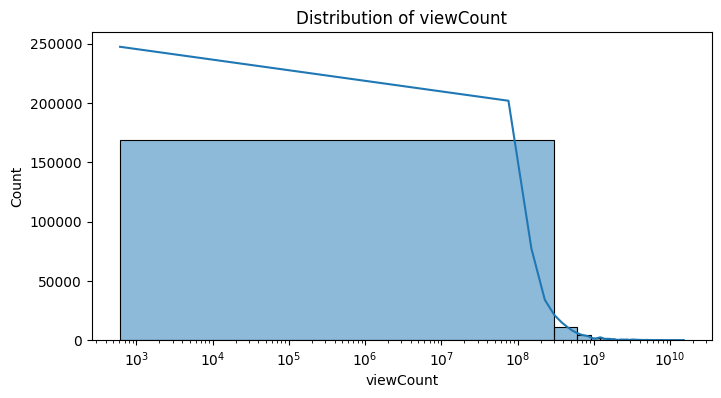

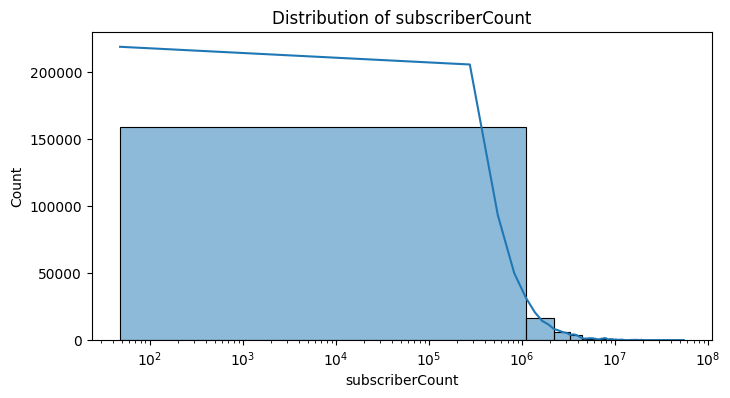

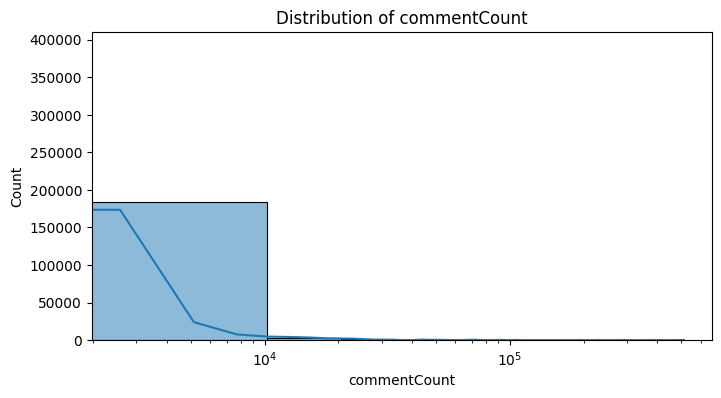

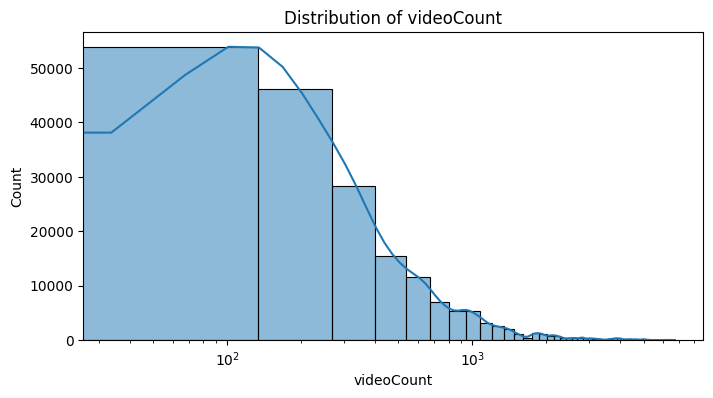

In [ ]:
# Log-scaled distributions of core features
for col in ['viewCount', 'subscriberCount', 'commentCount', 'videoCount']:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.xscale('log')
    plt.title(f'Distribution of {col}')
    plt.show()


 Reveals spread and skew in metrics; outliers and log-normal behavior are common in social media data like this.

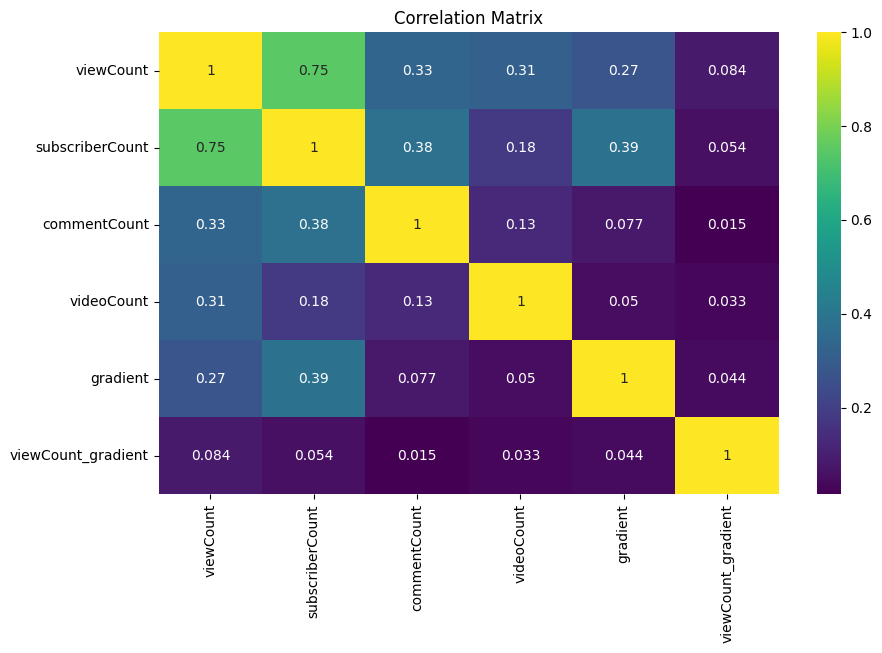

In [ ]:
df_growth = df.dropna(subset=['gradient', 'viewCount_gradient'])

plt.figure(figsize=(10,6))
sns.heatmap(df_growth[['viewCount', 'subscriberCount', 'commentCount', 'videoCount', 'gradient', 'viewCount_gradient']].corr(), annot=True, cmap='viridis')
plt.title("Correlation Matrix")
plt.show()


Shows how growth metrics (gradients) relate to total metrics — useful to understand whether high views lead to subs or if they're independent.

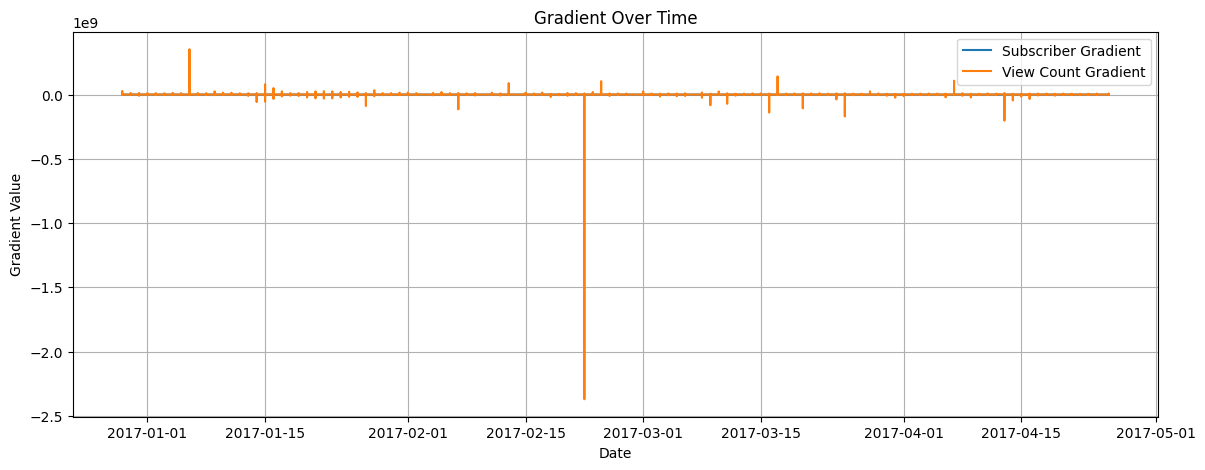

In [ ]:
df_sorted = df_growth.sort_values(by='crawlTimestamp')

plt.figure(figsize=(14,5))
plt.plot(df_sorted['crawlTimestamp'], df_sorted['gradient'], label='Subscriber Gradient')
plt.plot(df_sorted['crawlTimestamp'], df_sorted['viewCount_gradient'], label='View Count Gradient')
plt.legend()
plt.title('Gradient Over Time')
plt.xlabel('Date')
plt.ylabel('Gradient Value')
plt.grid(True)
plt.show()


Tracks how subscriber and view growth changes over time — highlights peaks, dips, and overall trends in the crawling period.

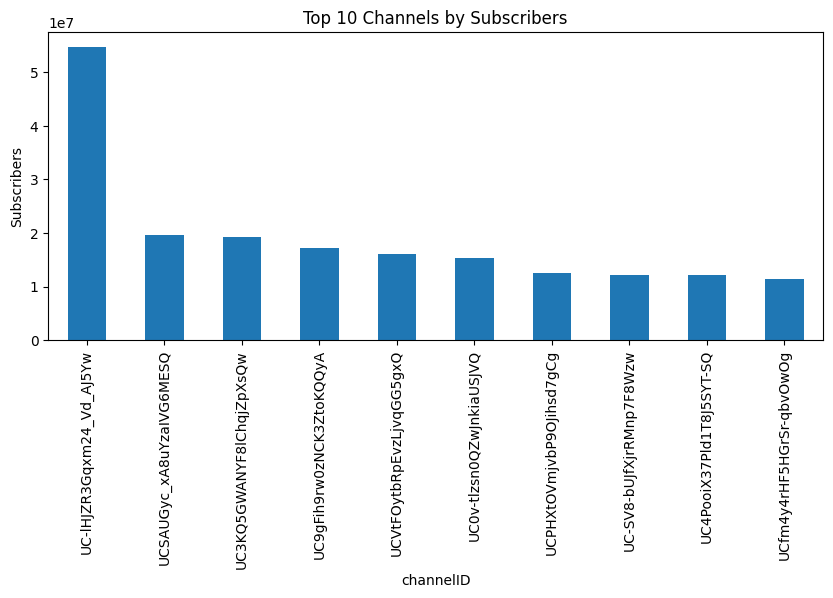

In [ ]:
top_subs = df.groupby('channelID')['subscriberCount'].max().sort_values(ascending=False).head(10)
top_subs.plot(kind='bar', figsize=(10,4), title='Top 10 Channels by Subscribers')
plt.ylabel('Subscribers')
plt.show()


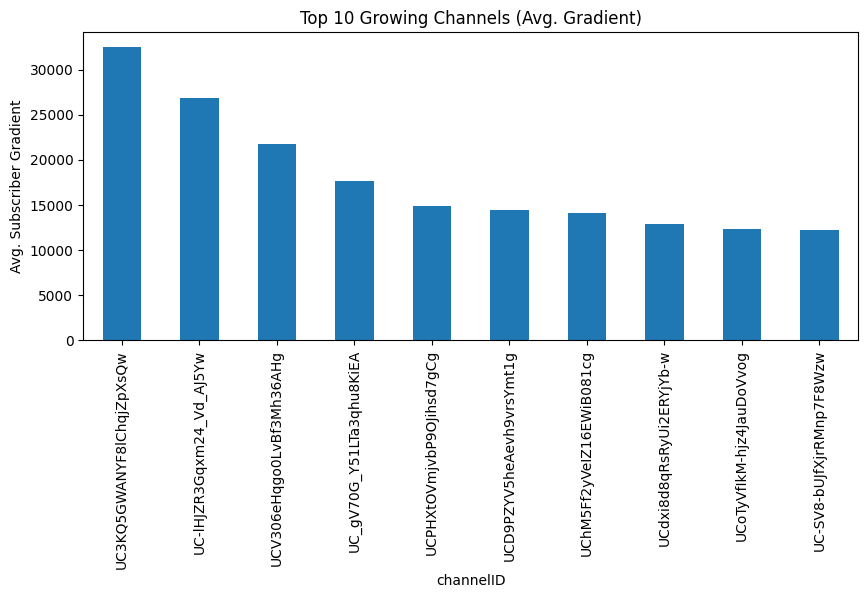

In [ ]:
top_growth = df_growth.groupby('channelID')['gradient'].mean().sort_values(ascending=False).head(10)
top_growth.plot(kind='bar', figsize=(10,4), title='Top 10 Growing Channels (Avg. Gradient)')
plt.ylabel('Avg. Subscriber Gradient')
plt.show()


In [ ]:
active_channels = df[df['videoCount'] > 50]['channelID'].nunique()
total_channels = df['channelID'].nunique()
print(f"\nActive Channels (videoCount > 50): {active_channels} / {total_channels}")



Active Channels (videoCount > 50): 1482 / 1599


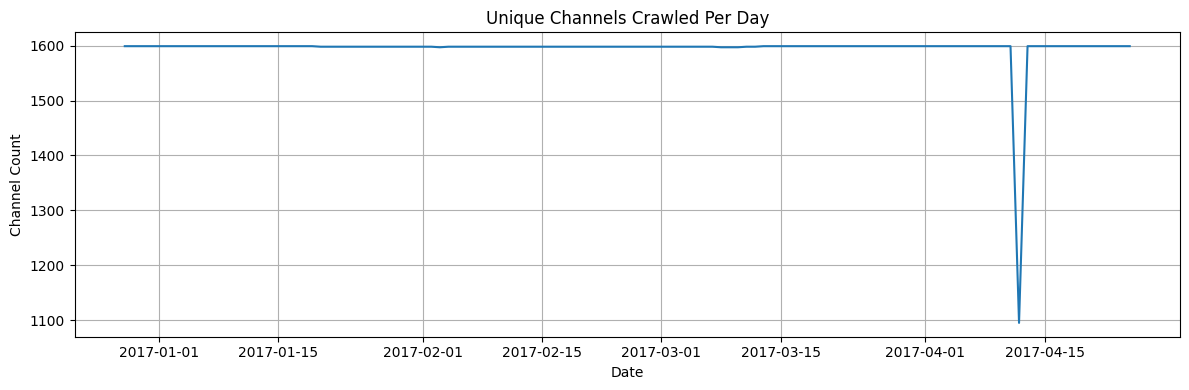

In [ ]:
df['date'] = df['crawlTimestamp'].dt.date
daily_activity = df.groupby('date')['channelID'].nunique()

plt.figure(figsize=(12,4))
daily_activity.plot()
plt.title("Unique Channels Crawled Per Day")
plt.xlabel("Date")
plt.ylabel("Channel Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
missing_gradient = df[df['gradient'].isna()]
present_gradient = df[df['gradient'].notna()]

print(f"\nRows before gradient starts appearing: {len(missing_gradient)}")
print(f"Gradient starts from: {present_gradient['crawlTimestamp'].min()}")



Rows before gradient starts appearing: 1599
Gradient starts from: 2016-12-29 00:00:03


In [ ]:
# Drop rows without gradients before aggregation
df_clean = df.dropna(subset=['gradient'])

# Aggregate per unique channel
channel_summary = df_clean.groupby('channelID').agg({
    'gradient': 'mean',                      # average subscriber gradient
    'viewCount_gradient': 'mean',            # average view gradient
    'subscriberCount': 'max',                # peak subscriber count seen
    'viewCount': 'max',                      # peak view count
    'commentCount': 'mean',                  # avg comment count
    'videoCount': 'max',                     # max video uploads seen
    'crawlTimestamp': 'count'                # how many times the channel was crawled
}).reset_index()

channel_summary.rename(columns={
    'gradient': 'avg_subscriber_gradient',
    'viewCount_gradient': 'avg_view_gradient',
    'crawlTimestamp': 'crawl_freq'
}, inplace=True)

channel_summary.head()



,channelID,avg_subscriber_gradient,avg_view_gradient,subscriberCount,viewCount,commentCount,videoCount,crawl_freq
0,UC-4kjzuh4822B9yPSgpZQgA,4125.277311,275369.428571,1725319,61440188.0,0.0,80,119
1,UC-63s9JLCZqIDlhXK6VHb7w,2.243697,2697.630252,27873,9155189.0,0.0,99,119
2,UC-A4oZF4AlOEdlyZWBCI0cQ,85.168067,73245.596639,1652754,346406755.0,3676.0,559,119
3,UC-CRXGRabkMD7x6V_Nk9F0A,17.621849,4528.327731,4949,1013518.0,0.0,234,119
4,UC-NINtNMPM75eaqh07RCy_Q,667.126050,491048.789916,929946,684511092.0,21.0,5249,119


In [ ]:
# Number of unique channels
unique_channels = df['channelID'].nunique()
print(f"🔢 Number of unique channels: {unique_channels}")


🔢 Number of unique channels: 1599


In [ ]:
q1 = channel_summary['avg_subscriber_gradient'].quantile(0.33)
q2 = channel_summary['avg_subscriber_gradient'].quantile(0.66)

def growth_label(g):
    if g <= q1:
        return 'Low'
    elif g <= q2:
        return 'Medium'
    else:
        return 'High'

channel_summary['growth_category'] = channel_summary['avg_subscriber_gradient'].apply(growth_label)


<ipython-input-6-c83d9379f8ed>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='growth_category', data=channel_summary, palette='Set2')


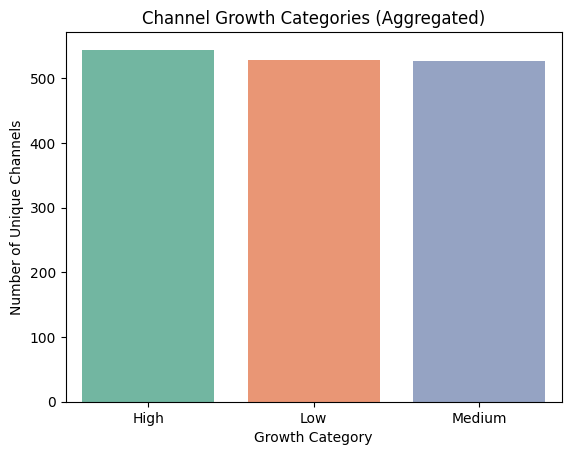

In [ ]:
sns.countplot(x='growth_category', data=channel_summary, palette='Set2')
plt.title("Channel Growth Categories (Aggregated)")
plt.xlabel("Growth Category")
plt.ylabel("Number of Unique Channels")
plt.show()


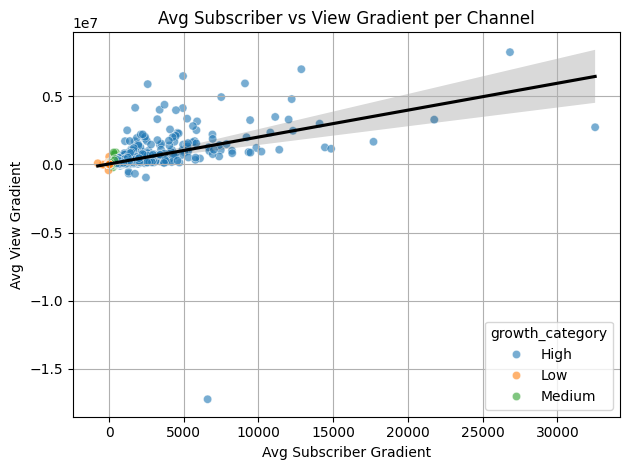

In [ ]:
sns.scatterplot(
    data=channel_summary,
    x='avg_subscriber_gradient',
    y='avg_view_gradient',
    hue='growth_category',
    alpha=0.6
)
sns.regplot(
    data=channel_summary,
    x='avg_subscriber_gradient',
    y='avg_view_gradient',
    scatter=False,
    color='black'
)
plt.title('Avg Subscriber vs View Gradient per Channel')
plt.xlabel('Avg Subscriber Gradient')
plt.ylabel('Avg View Gradient')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
declining_channels = channel_summary[channel_summary['avg_subscriber_gradient'] < 0]
inactive_channels = channel_summary[(channel_summary['avg_subscriber_gradient'] <= 0.001) & (channel_summary['videoCount'] < 5)]

print(f" Declining Channels: {len(declining_channels)}")
print(f"Inactive Channels: {len(inactive_channels)}")


 Declining Channels: 63
Inactive Channels: 0


In [ ]:
# Use the previously aggregated `channel_summary`
top_growing = channel_summary.sort_values('avg_subscriber_gradient', ascending=False).head(3)['channelID'].tolist()
top_declining = channel_summary.sort_values('avg_subscriber_gradient').head(3)['channelID'].tolist()

selected_channels = top_growing + top_declining


In [ ]:
# Ensure timestamp is datetime
df['crawlTimestamp'] = pd.to_datetime(df['crawlTimestamp'])

# Filter only selected channels
df_selected = df[df['channelID'].isin(selected_channels)]

# Sort by timestamp for time-series plotting
df_selected = df_selected.sort_values(by=['channelID', 'crawlTimestamp'])


<ipython-input-12-ef802eeb4db5>:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


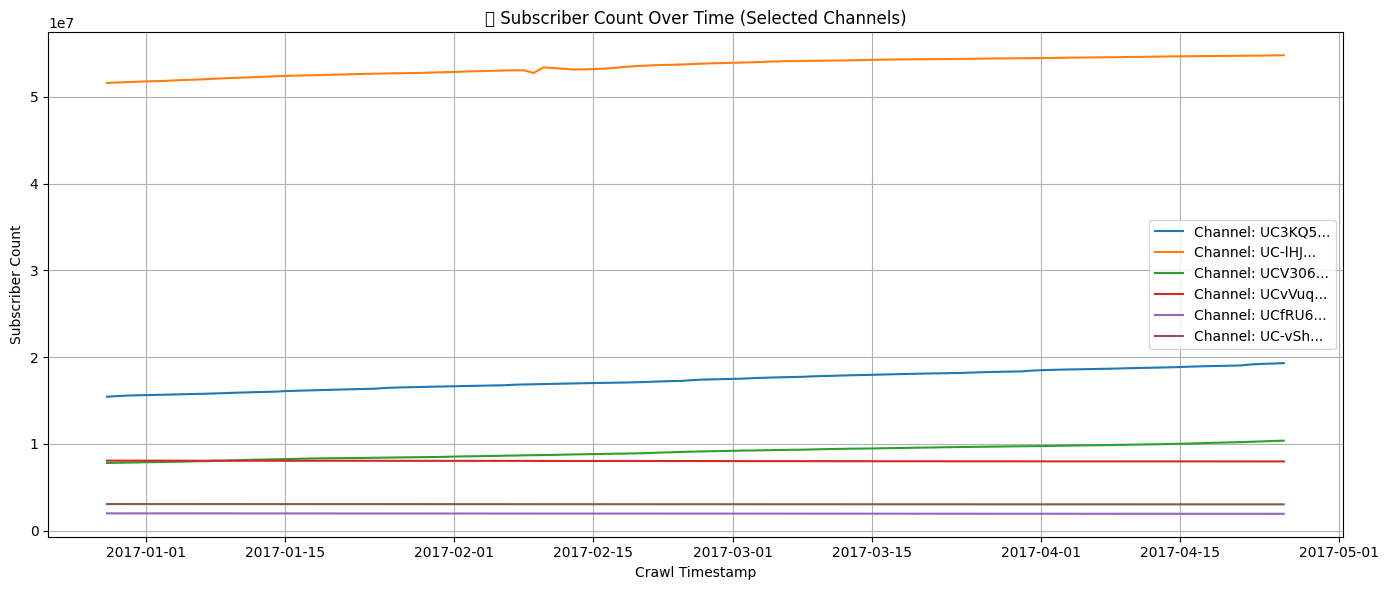

In [ ]:
plt.figure(figsize=(14, 6))

for ch in selected_channels:
    temp = df_selected[df_selected['channelID'] == ch]
    plt.plot(temp['crawlTimestamp'], temp['subscriberCount'], label=f'Channel: {ch[:6]}...')

plt.title("📈 Subscriber Count Over Time (Selected Channels)")
plt.xlabel("Crawl Timestamp")
plt.ylabel("Subscriber Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##Function to analyze stats of a particular channel using its ID

In [8]:
def analyze_channel(channel_id, df):
    sns.set(style="whitegrid")

    # Filter for that channel
    channel_df = df[df['channelID'] == channel_id].sort_values(by='crawlTimestamp')

    if channel_df.empty:
        print("Channel ID not found.")
        return

    print(f"Showing analysis for Channel ID: {channel_id}")

    # Convert timestamp to datetime
    channel_df['crawlTimestamp'] = pd.to_datetime(channel_df['crawlTimestamp'])

    # Plot 1: ViewCount over time
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=channel_df, x='crawlTimestamp', y='viewCount', marker="o")
    plt.title("View Count Growth Over Time")
    plt.xlabel("Date")
    plt.ylabel("View Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot 2: Subscriber count over time
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=channel_df, x='crawlTimestamp', y='subscriberCount', marker="o", color='orange')
    plt.title("Subscriber Growth Over Time")
    plt.xlabel("Date")
    plt.ylabel("Subscriber Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot 3: p_gradient (growth rate) over time
    if 'p_gradient' in channel_df.columns:
        plt.figure(figsize=(12, 4))
        sns.lineplot(data=channel_df, x='crawlTimestamp', y='p_gradient', marker="o", color='green')
        plt.title("Subscriber Growth Rate (p_gradient) Over Time")
        plt.xlabel("Date")
        plt.ylabel("p_gradient")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Collaboration info
    collabs = channel_df[channel_df['collab_window'].notna() & (channel_df['collab_window'] != 0)]

    if not collabs.empty:
        print("\n Collaboration Window(s) Detected:")
        for i, row in collabs.iterrows():
            print(f"- On {row['crawlTimestamp'].date()}, collab window: {row['collab_window']}")
    else:
        print("\nℹ No collaborations found in 3 months.")

    # Optionally: return filtered data for further exploration
    return channel_df

Showing analysis for Channel ID: UC-4kjzuh4822B9yPSgpZQgA


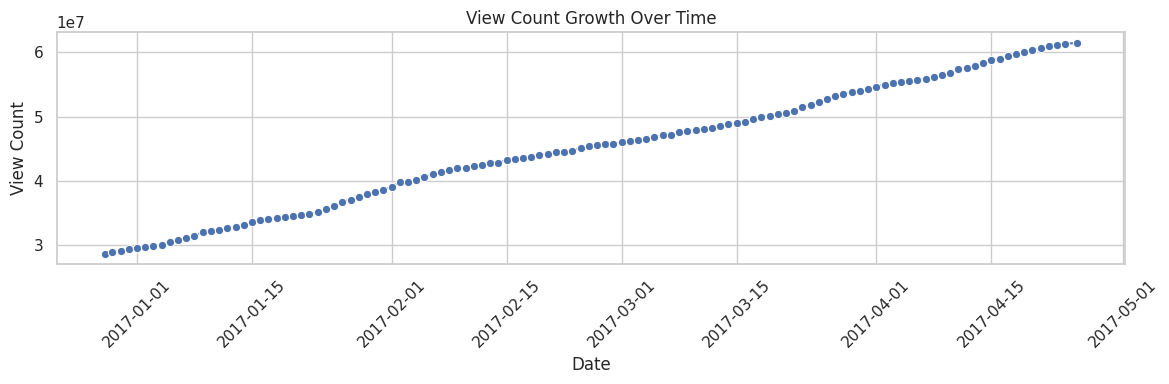

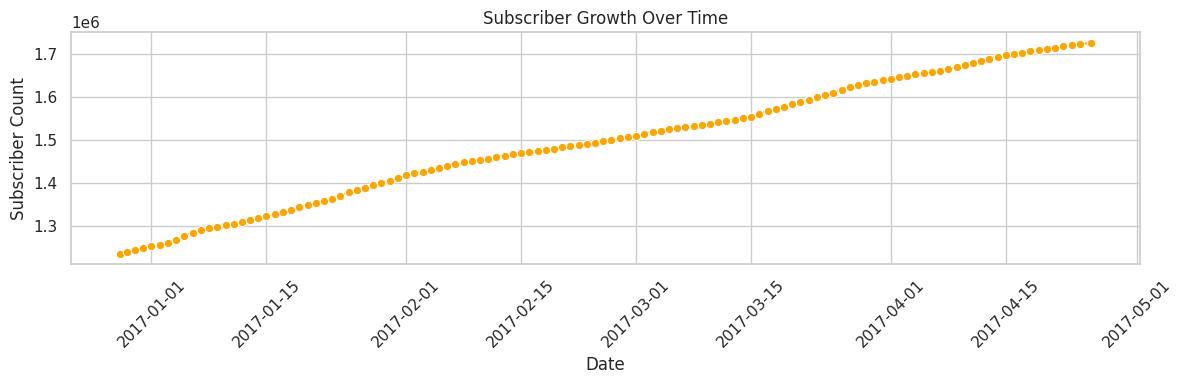

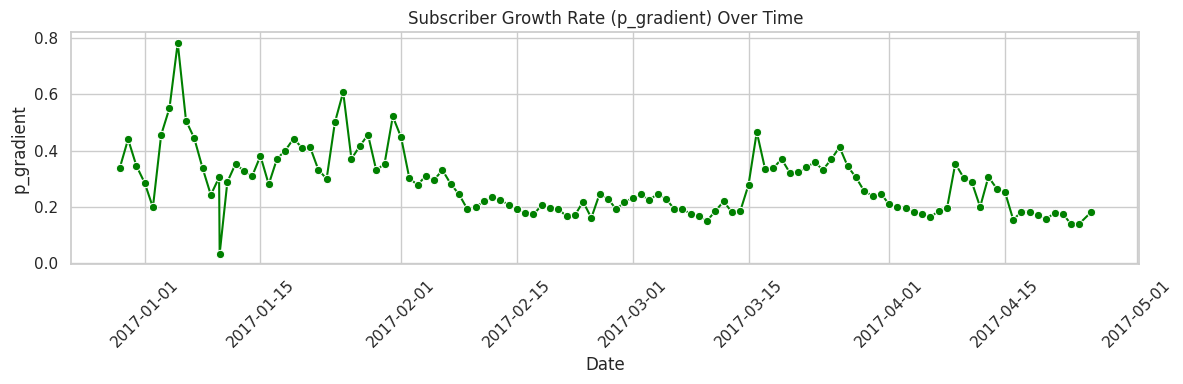


 Collaboration Window(s) Detected:
- On 2016-12-29, collab window: Non_Collab
- On 2016-12-30, collab window: Non_Collab
- On 2017-01-03, collab window: Non_Collab
- On 2017-01-04, collab window: Non_Collab
- On 2017-01-07, collab window: Non_Collab
- On 2017-01-08, collab window: Non_Collab
- On 2017-01-12, collab window: Non_Collab
- On 2017-01-13, collab window: Non_Collab
- On 2017-01-14, collab window: Non_Collab
- On 2017-01-15, collab window: Non_Collab
- On 2017-01-17, collab window: Non_Collab
- On 2017-01-18, collab window: Non_Collab
- On 2017-01-19, collab window: Non_Collab
- On 2017-01-20, collab window: Non_Collab
- On 2017-01-24, collab window: Non_Collab
- On 2017-01-25, collab window: Non_Collab
- On 2017-01-26, collab window: Non_Collab
- On 2017-01-27, collab window: Non_Collab
- On 2017-01-28, collab window: Non_Collab
- On 2017-01-30, collab window: Non_Collab
- On 2017-01-31, collab window: Non_Collab
- On 2017-02-01, collab window: Non_Collab
- On 2017-02-04, c

In [10]:
stats =analyze_channel("UC-4kjzuh4822B9yPSgpZQgA",df)